# **Preparing a Churn Prediction Model with Python and PySpark**


Churn prediction models are crucial for companies to identify which customers might soon leave. It is one of the best ways to leverage your data since this insight allows businesses to implement targeted retention strategies effectively.

In this project, I built a model using PySpark and Python. Building these models requires expertise in Python, including skills in data manipulation, machine learning, and statistical analysis to interpret customer data and predict behaviors. This proactive approach helps in improving customer satisfaction and loyalty.

This is an educational example. The dataset has been anonimized. It shows information of 7,043 clients from a communication company.

Go to this link for a explicative [slides presentation](https://docs.google.com/presentation/d/1RWxm0NhXG7zA7D6eWS9F8gPYcJg3GLEi3Fzz6YXcaio/edit?usp=sharing) of the main findings.


### **Task 1 - Loading our data and packages**

Installing the pyspark using pip

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c142096574503192c6b6f2d4451fa2352af56dbf845309b918d177d8868022a4
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Importing Modules

In [ ]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules
import matplotlib.pyplot as plt
import plotly.express as px

# pandas module
import pandas as pd

# pyspark SQL functions
from pyspark.sql.functions import col, when, count, udf

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Building our Spark Session

In [ ]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

Loading our data

In [ ]:
data = spark.read.format('csv').option("inferSchema", True).option("header", True).load("dataset.csv")
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Print the data schema to check out the data types

In [ ]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Get the data dimension

In [ ]:
print(data.count(), 'x', len(data.columns))


7043 x 21


### **Task 2 - Exploratory Data Analysis**
Let's have a look real quick at our data. What info do we have?

We will do some:

- Distribution Analysis
- Correlation Analysis
- Univariate Analysis
- Finding Missing values

Let's define some lists to store different column names with different data types.

In [ ]:
numerical_columns = [name for name,typ in data.dtypes if typ == "double" or typ== "int"]
categorical_columns = [name for name,typ in data.dtypes if typ == "string"]

Let's get all the numerical features and store them into a pandas dataframe.

In [ ]:
numerical_df = data.select(numerical_columns).toPandas()
numerical_df.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Let's create histograms to analyse the distribution of our numerical columns.

<ipython-input-28-ac6786d9eca6>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  numerical_df.hist(ax=ax, bins=20)


array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>],
       [<Axes: title={'center': 'TotalCharges'}>, <Axes: >]], dtype=object)

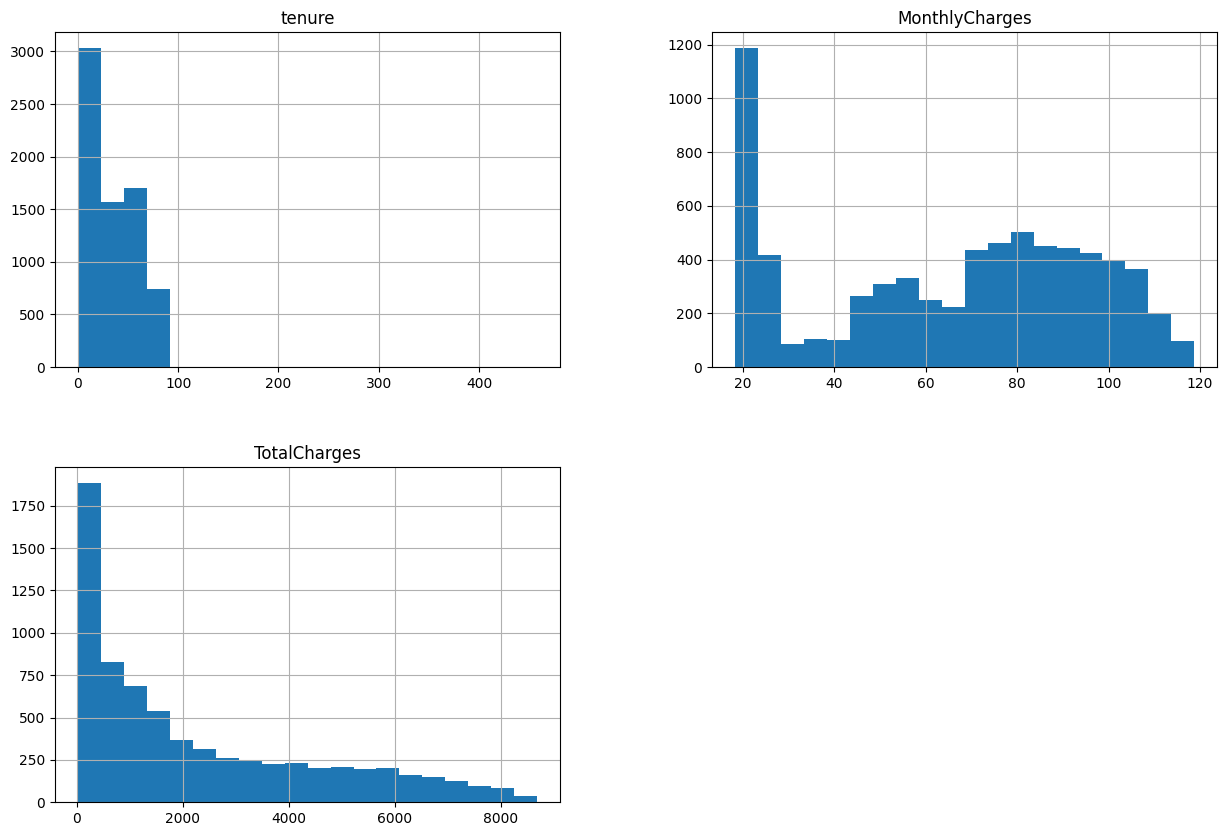

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
numerical_df.hist(ax=ax, bins=20)

In [ ]:
numerical_df.tenure.describe()

count    7043.000000
mean       32.435752
std        25.075228
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max       458.000000
Name: tenure, dtype: float64

Let's generate the correlation matrix

In [ ]:
numerical_df.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.243703,0.805474
MonthlyCharges,0.243703,1.000000,0.650468
TotalCharges,0.805474,0.650468,1.000000


Let's check the unique value count per each categorical variables

> Add blockquote



In [ ]:
for column in categorical_columns:
  data.groupby(column).count().show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682

Let's find number of null values in all of our dataframe columns

In [ ]:
for column in data.columns:
  data.select(count(when(col(column).isNull(), column)).alias(column)).show()

+----------+
|customerID|
+----------+
|         0|
+----------+

+------+
|gender|
+------+
|     0|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            0|
+-------------+

+-------+
|Partner|
+-------+
|      0|
+-------+

+----------+
|Dependents|
+----------+
|         0|
+----------+

+------+
|tenure|
+------+
|     0|
+------+

+------------+
|PhoneService|
+------------+
|           0|
+------------+

+-------------+
|MultipleLines|
+-------------+
|            0|
+-------------+

+---------------+
|InternetService|
+---------------+
|              0|
+---------------+

+--------------+
|OnlineSecurity|
+--------------+
|             0|
+--------------+

+------------+
|OnlineBackup|
+------------+
|           0|
+------------+

+----------------+
|DeviceProtection|
+----------------+
|               0|
+----------------+

+-----------+
|TechSupport|
+-----------+
|          0|
+-----------+

+-----------+
|StreamingTV|
+-----------+
|          0|
+----------

### **Task 3 - Data Preprocessing**
Ok, now we have to clean the data:
- Handling the missing values
- Removing the outliers

**Handling the missing values** <br>
Let's create a list of column names with missing values

In [ ]:
columns_missing_values = ["TotalCharges"]

Creating our Imputer

In [ ]:
imputer = Imputer(inputCols = columns_missing_values, outputCols=columns_missing_values).setStrategy("mean")

Use Imputer to fill the missing values

In [ ]:
imputer = imputer.fit(data)


In [ ]:
data = imputer.transform(data)

Let's check the missing value counts again

**Removing the outliers** <br>
Let's find the customer with the tenure higher than 100

In [ ]:
data.select('*').where(data.tenure >100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

Let's drop the outlier row

In [ ]:
print(data.count())
data = data.filter(data.tenure < 100)
print(data.count())

7043
7042


### **Task 4 - Feature Preparation**
This is one of the most important steps, our model only admits numerical info and one column. So we would have to translate are object values. For example, our 'internet services column, which has three possible values (Fiber optic, DSL, and No), will have to become 0,1,3.

And then, we will have to push them all into a vector in a sole column.
- Numerical Features
    - Vector Assembling
    - Numerical Scaling
- Categorical Features
    - String Indexing
    - Vector Assembling

- Combining the numerical and categorical feature vectors



In [ ]:
numerical_vector_assembler = VectorAssembler(inputCols = numerical_columns, outputCol='numerical_features_vector')
data = numerical_vector_assembler.transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+----------

**Numerical Scaling** <br>
Let's standardize all of our numerical features.

In [ ]:
scaler = StandardScaler(inputCol = "numerical_features_vector",
                       outputCol = "numerical_features_scaled", withStd=True, withMean=True)
data = scaler.fit(data).transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|numerical_features_scaled|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------

**Feature Preperation - Categorical Features** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
We need to convert all the string columns to numeric columns.

In [ ]:
categorical_columns_indexed = [name + "_indexed" for name in categorical_columns]

indexer = StringIndexer(inputCols = categorical_columns, outputCols=categorical_columns_indexed)
data = indexer.fit(data).transform(data)


Because CustomerId is not necessary, and Churn is indeed our target column, I am going to remove them

In [ ]:
categorical_columns_indexed.remove('customerID_indexed')
categorical_columns_indexed.remove('Churn_indexed')

categorical_vector_assembler = VectorAssembler(inputCols = categorical_columns_indexed,outputCol = "categorical_features_vector")
data = categorical_vector_assembler.transform(data)

data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+---------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contrac

Let's combine all of our categorifal features in to one feature vector.

Now let's combine categorical and numerical feature vectors.

In [ ]:
final_vector_assembler = VectorAssembler(inputCols=["categorical_features_vector","numerical_features_scaled"], outputCol= 'Final_feature_vector')
data = final_vector_assembler.transform(data)
data.select(['Final_feature_vector', 'Churn_indexed']).show()

+--------------------+-------------+
|Final_feature_vector|Churn_indexed|
+--------------------+-------------+
|(19,[0,2,4,5,6,8,...|          0.0|
|(19,[6,7,9,13,14,...|          0.0|
|(19,[6,7,8,15,16,...|          1.0|
|[0.0,0.0,0.0,0.0,...|          0.0|
|(19,[0,16,17,18],...|          1.0|
|(19,[0,5,9,11,12,...|          1.0|
|(19,[3,5,8,11,15,...|          0.0|
|(19,[0,4,5,6,7,14...|          0.0|
|(19,[0,2,5,9,10,1...|          1.0|
|(19,[3,6,7,8,13,1...|          0.0|
|(19,[2,3,6,7,15,1...|          0.0|
|[0.0,0.0,0.0,0.0,...|          0.0|
|(19,[2,5,9,11,12,...|          0.0|
|(19,[5,8,9,11,12,...|          1.0|
|(19,[7,9,10,11,12...|          0.0|
|[1.0,0.0,1.0,1.0,...|          0.0|
|[1.0,0.0,0.0,0.0,...|          0.0|
|[0.0,0.0,0.0,1.0,...|          0.0|
|(19,[0,2,3,6,9,10...|          1.0|
|(19,[0,8,9,12,16,...|          0.0|
+--------------------+-------------+
only showing top 20 rows



### **Task 5 - Model Training**

In this task,  we will create the model and train it using our data:

- Train and Test data splitting
- Creating our model
- Training our model
- Make initial predictions using our model


In [ ]:
train, test = data.randomSplit([0.7,0.3], seed=100)

train.count()


4930

In [ ]:
test.count()

2112

Now let's create and train our desicion tree

In [ ]:
dt = DecisionTreeClassifier(featuresCol = 'Final_feature_vector', labelCol='Churn_indexed', maxDepth=6)
model = dt.fit(train)

Let's make predictions on our test data

In [ ]:
predictions_test = model.transform(test)
predictions_test.select('Churn', "prediction").show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|  Yes|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       1.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
+-----+----------+
only showing top 20 rows



### **Task 6 - Model Evaluation**
- Calculating area under the ROC curve for the `test` set
- Calculating area under the ROC curve for the `training` set
- Hyper parameter tuning\

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds.

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed')
auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName:"areaUnderROC"})
auc_test

0.7968240892739675

Let's get the AUC for our `training` set

AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).



In [ ]:
predictions_train = model.transform(train)
auc_train = evaluator.evaluate(predictions_train, {evaluator.metricName:"areaUnderROC"})
auc_train

0.797607974377661

**Hyper parameter tuning**

Let's find the best `maxDepth` parameter for our DT model.

In [ ]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'Final_feature_vector', labelCol = 'Churn_indexed', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)

Let's define `params` list to evaluate our model iteratively with differe maxDepth parameter.  

In [ ]:
maxDepths = list(range(2, 21))

test_accs, train_accs = evaluate_dt(maxDepths)
print(train_accs)
print(test_accs)

[0.7737711024910238, 0.7721112330375414, 0.6732017750857608, 0.5647403286677019, 0.797607974377661, 0.7600331160893413, 0.7616399322585649, 0.7851198149534798, 0.82591977092655, 0.8633625692715379, 0.8899907318309699, 0.9236516335825413, 0.9402616892332477, 0.9521037242780167, 0.9662424766482165, 0.9763120733848871, 0.9807472862567603, 0.9853808496196841, 0.9883361989750398]
[0.7918744332963926, 0.7678230877272001, 0.6938514510575503, 0.5664944085244075, 0.7968240892739675, 0.7464077658395512, 0.7486976928866473, 0.7390283218461648, 0.7568262227463716, 0.7717528253693575, 0.770466222983424, 0.7493673661690539, 0.7371905724224987, 0.7208594338001293, 0.7102797812005524, 0.704298946894316, 0.7036452746549405, 0.6956814962753128, 0.6895714683623821]


Let's visualize our results

In [ ]:
df = pd.DataFrame()
df['maxDepth'] = maxDepths
df['trainAcc'] = train_accs
df['testAcc'] = test_accs
px.line(df, x = "maxDepth", y=['trainAcc', 'testAcc'])

WE see that the optimun maxDepth is 6.

### **7 - Model Deployment**
- Giving Recommendations using our model



We were asked to recommend a solution to reduce the customer churn.

We have to find the features that have the greatest impact in finding churn return.


In [ ]:
feature_importance = model.featureImportances
scores = [score for i,score in enumerate(feature_importance)]
df = pd.DataFrame(scores, columns=['score'],index = categorical_columns_indexed+numerical_columns)
df = df.sort_values(by='score', ascending=False)

px.bar(df, y='score',  color_discrete_sequence=['#AEACFF'], title='Feature Importance to Churn')

Let's create a bar chart to visualize the customer churn per contract type

In [ ]:
df = data.groupby(["Contract", "Churn"]).count().toPandas()

px.bar(df, x="Contract", y='count', color='Churn',color_discrete_sequence=['#AEACFF', '#9cdbd6'], title='Churn Rate by Contract Type')

The bar chart displays the number of churned customers based on their contract type. It is evident that customers with a "Month-to-month" contract have a higher churn rate compared to those with "One year" or "Two year" contracts. As a recommendation, the telecommunication company could consider offering incentives or discounts to encourage customers with month-to-month contracts to switch to longer-term contracts.

Let's check now the other prominent features.

I am going to ignore the tenure length one, since it is more a byproduct of other factors.

However, I will focus on the third one: Internet Service type.

In [ ]:
df = data.groupby(["internetService", "Churn"]).count().toPandas()

px.bar(df, x="internetService", y='count', color='Churn',color_discrete_sequence=['#9cdbd6','#AEACFF'], title='Churn by Internet Service Type')

We can see that the Fiber Optic users tend to leave the service more often. So we could deduce that there is something wrong with the Fiber Optic service.

but wait!

Before making a recommendation, we need to check if this is due to the service, or another factor, like, for example, the nature of the contract.

In [ ]:
fiber_optic_data = data[data['internetService'] == 'Fiber optic']

contract_distribution = fiber_optic_data.groupby('Contract').count().toPandas()
# Create a pie chart
fig = px.pie(contract_distribution, names='Contract', values='count',color_discrete_sequence=['#9cdbd6','#AEACFF', '#11c1be'],
             title='Distribution of Contract Types for Fiber Optic Service')
fig.show()

Indeed, we see that most of the Fiber optic clients are month-to-month customers. So that might explain why they have higher churn rates. Not because of the service in itself, but because they are mostly temporary clients due to external factors.

Let's check again the churn rate by internet services but only for long-term contracts.

In [ ]:
long_term = data[data['Contract'].isin(['One year','Two year'])]
df = long_term.groupby(["internetService", "Churn"]).count().toPandas()

px.bar(df, x="internetService", y='count', color='Churn',color_discrete_sequence=['#9cdbd6','#AEACFF'], title='Churn by Internet Service Type for long-term contracts')

And indeed, even among the long-term contract, which are the most loyal customers, Fiber optic services show a higher churn.

Therefore, it makes us confident enought to suggest double checking what's going on in those services. Perhaps their quality is not as high as expected.

Don't forget to check the explicative [slides presentation](https://docs.google.com/presentation/d/1RWxm0NhXG7zA7D6eWS9F8gPYcJg3GLEi3Fzz6YXcaio/edit?usp=sharing).

In [ ]:
()